## Описание

На этот раз данные имеют следующую структуру:
* записываются для каждого пользователя, совершившего покупки, каждый день
* для каждой даты есть своя папка, внутри неё – папки для каждого пользователя
* внутри каждой папки есть файл data.csv, где и хранятся данные

Схематично выглядит так:
* data:
    * 2020-12-30:
        * FirstName_LastName1:
            * data.csv
        * FirstName_LastName2:
            * data.csv
        * FirstName_LastName3:
            * data.csv
    * 2020-12-31:
        * FirstName_LastName1:
            * data.csv
        * FirstName_LastName5:
            * data.csv

Например, 30 декабря три покупателя сделали покупки, 31 – два (папки 2020-12-30 и 2020-12-31 соответственно). Поскольку клиент FirstName_LastName1 купил товары в оба дня, для него имеется папка в папке для каждой из дат. Для других клиентов – по одной.

Note: данные в задании покрывают другой временной период, имена тоже другие.

#### Задачи
<ol>
<li>Соберите все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id, quantity), а также имя пользователя (name), и дата этих покупок (date), соответствует названию папки, где лежит папка с пользователем)</li>
<li>Выясните, какой пользователь купил больше всего товаров. Если их несколько, то перечислите имена через запятую с пробелом и в алфавитном порядке.</li>
<li>Найдите топ-10 товаров по числу проданных единиц за всё время и постройте барплот. Сколько было продано единиц товара с product_id==56?</li>
<li>Визуализируйте продажи по дням.</li>
<li>Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни. </li>
</ol>

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Создание датафрэйма и добавление в него всех имеющихся данных
df = pd.DataFrame()

for path, dirs, files in os.walk('data'):
    for file in files:
        temp_df = pd.read_csv(f'{path}\\{file}', usecols=['product_id', 'quantity'])
        temp_df['name'] = path.split("\\")[-1]
        temp_df['date'] = path.split("\\")[-2]
        df = pd.concat([df, temp_df], ignore_index=True)

In [3]:
# Получение того же результата при помощи библиотеки Pathlib (Вариант 1)
from pathlib import Path

df = pd.DataFrame()

for path, dirs, files in os.walk('data'):
    for file in files:
        part_path = Path(path)
        data_path = part_path / file
        temp_df = pd.read_csv(data_path, usecols=['product_id', 'quantity'])
        temp_df['name'] = data_path.parts[-2]
        temp_df['date'] = data_path.parts[-3]
        df = pd.concat([df, temp_df], ignore_index=True)

In [4]:
# Получение того же результата при помощи библиотеки Pathlib (Вариант 2)
df = pd.DataFrame()
path = Path('data')
for csv_path in path.glob('**/*.csv'):
    temp_df = pd.read_csv(csv_path, usecols=['product_id', 'quantity'])
    temp_df['name'] = csv_path.parts[-2]
    temp_df['date'] = csv_path.parts[-3]
    df = pd.concat([df, temp_df], ignore_index=True)

In [5]:
# Посмотрим на датафрэйм, типы колонок и форму
display(df.head())
display(df.dtypes)
df.shape

,product_id,quantity,name,date
0,47,1,Alexey_Smirnov,2020-12-03
1,57,1,Alexey_Smirnov,2020-12-03
2,14,2,Alexey_Smirnov,2020-12-03
3,52,1,Alexey_Smirnov,2020-12-03
4,1,4,Alexey_Smirnov,2020-12-03


product_id     int64
quantity       int64
name          object
date          object
dtype: object

(161, 4)

In [6]:
df.quantity.sum()

480

In [7]:
# Определим пользователя(ей), с наибольшим числом покупок
max_purcheses = df.groupby('name').quantity.sum().max()
users_purcheses = df.groupby('name', as_index=False) \
                    .quantity.sum() \
                    .rename(columns={'quantity':'num_purcheses'})
users_with_max_purcheses = ', '.join(users_purcheses.query('num_purcheses == @max_purcheses') \
                                                    .name.sort_values()\
                                                    .to_list())
users_with_max_purcheses

'Alexey_Smirnov, Petr_Smirnov'

In [8]:
# Найдем Топ-10 самых продоваемых товаров и построим барплот
top_10_products_df = df.groupby('product_id', as_index=False) \
                        .quantity.sum() \
                        .sort_values('quantity', ascending=False) \
                        .head(10)

<AxesSubplot:xlabel='product_id', ylabel='quantity'>

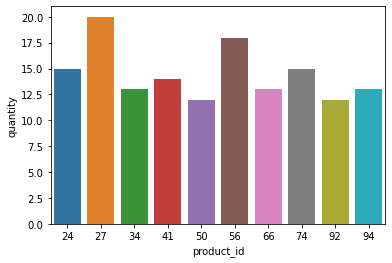

In [9]:
sns.barplot(x='product_id', y='quantity', data=top_10_products_df)

In [10]:
top_10_products_df.query('product_id == 56')

,product_id,quantity
42,56,18


In [11]:
# Посмотрим на количество продаж по дням
num_purcheses_per_day = df.groupby('date', as_index=False) \
                          .quantity.sum()

<AxesSubplot:xlabel='date', ylabel='quantity'>

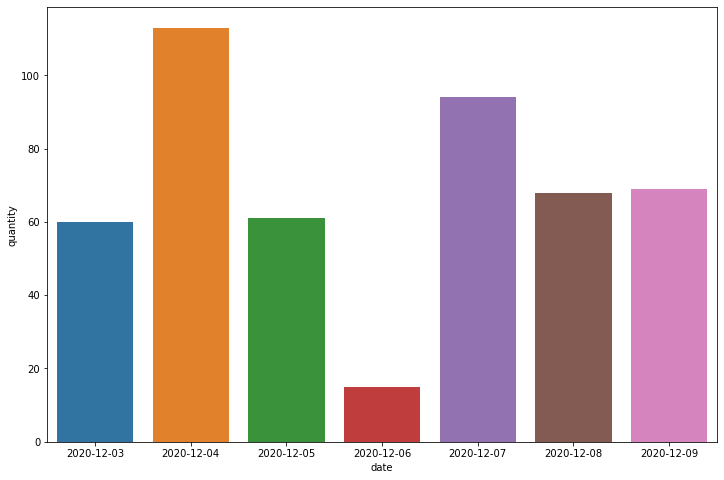

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(x='date', y='quantity', data=num_purcheses_per_day)

In [13]:
# Найдем количество пользователей, совершивших повторную покупку того же товара в другой день
df_without_dupl_in_day = df.drop_duplicates(subset=['name', 'product_id', 'date'])
df_without_dupl_in_day.loc[df_without_dupl_in_day.duplicated(subset=['name', 'product_id'], keep=False)].name.nunique()

2

In [14]:
# Еще один вариант решения
df.groupby(['name', 'product_id'], as_index=False) \
    .date.nunique() \
    .query('date > 1') \
    .name.count()

2